# 2-D Lattice Test #

In this example, we run the VBMDS-GP with the 2-D Lattice as a test

In [1]:
using Winston
using Distances
using Distributions

INFO: Recompiling stale cache file /Users/haroldsoh/.julia/lib/v0.4/Distributions.ji for module Distributions.
INFO: Recompiling stale cache file /Users/haroldsoh/.julia/lib/v0.4/ArrayViews.ji for module ArrayViews.
INFO: Recompiling stale cache file /Users/haroldsoh/.julia/lib/v0.4/PDMats.ji for module PDMats.
INFO: Recompiling stale cache file /Users/haroldsoh/.julia/lib/v0.4/StatsFuns.ji for module StatsFuns.
INFO: Recompiling stale cache file /Users/haroldsoh/.julia/lib/v0.4/StatsBase.ji for module StatsBase.


In [12]:
# create dataset
# generate simple grid
nX = 3^2
X = zeros(nX,2)
k = 1
for i = 1:sqrt(nX), j = 1:sqrt(nX)
    X[k,:] = 1.0*[i, j]
    k = k+1
end

Mdist = pairwise(Euclidean(), X').^2
k=1

nreps = 5
#nD = round(Int,((nX^2) - nX)/2)*nreps
nD = (nX^2 - nX)*nreps
println(nD)
D = zeros(nD, 3)
vn_true = 0.1
for reps = 1:nreps
    for i = 1:nX, j = 1:nX
        if i!=j
            d = LogNormal(log(Mdist[i,j]), sqrt(vn_true))
            D[k,:] = [i, j, rand(d) ]
            k = k+1
        end
    end
end


360


In [13]:
D

360x3 Array{Float64,2}:
 1.0  2.0   0.639344
 1.0  3.0   4.17377 
 1.0  4.0   0.788752
 1.0  5.0   2.11098 
 1.0  6.0   3.02903 
 1.0  7.0   2.14201 
 1.0  8.0   5.1223  
 1.0  9.0  10.3007  
 2.0  1.0   0.792818
 2.0  3.0   1.08558 
 2.0  4.0   1.43555 
 2.0  5.0   1.06516 
 2.0  6.0   1.54964 
 ⋮                  
 8.0  5.0   1.25576 
 8.0  6.0   2.30388 
 8.0  7.0   1.20943 
 8.0  9.0   0.886463
 9.0  1.0   7.10667 
 9.0  2.0   3.02189 
 9.0  3.0   4.59158 
 9.0  4.0   6.30133 
 9.0  5.0   3.4264  
 9.0  6.0   0.610189
 9.0  7.0   3.22338 
 9.0  8.0   0.905564

In [14]:
X # this are the true underlying positions. 

9x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3.0
 2.0  1.0
 2.0  2.0
 2.0  3.0
 3.0  1.0
 3.0  2.0
 3.0  3.0

In [15]:
# side information
# nonlinear transformation of the input coordinates
Xtest = [2*X[:,1].^2 X[:,1].*X[:,2]]
for i=1:size(Xtest,2)
    Xtest[:,i] = Xtest[:,i]./maximum(Xtest[:,i])
end
Xfeat = Xtest

# We set the inducing input locations with some noise
Xu = Xtest # inducing input locations
Xu = Xu + 0.05*rand(size(Xu))
println("Num Inducing inputs: ",size(Xu,1))

Num Inducing inputs: 9


In [16]:
include("vbmds.jl") # load in the VBMDS code

vbmds

In [20]:
# set up parameters
srand(0)

nZ = nX # number of latent points
num_lower_dim = 2 # number of latent dimensions
kfunc = vbmds.seARDkernel # kernel function
lbfunc = vbmds.lognormalEucMixLB #likelihood lower bound
#lbfunc = vbmds.normalSqEucLB
hyp = [sqrt(0.02*ones(size(Xfeat,2)))]# hyperparameters
m = [] # mean of inducing variables (set to [] if you want auto init)
v = [] # diagonal of inducing variables (set to [] if you want auto init)
mu = []
s2 = 10.0*ones(nZ, num_lower_dim)
vn = 0.1 #noise variance
m0 = [] # initial prior for m (Set to [] if you want auto)
v0 = [] # intiial prior for v (Set to [] if you want auto)
mu0 = []
s20 = .1*ones(nZ, num_lower_dim)
init_method = "random"# "random" for random initialization, "mds" for MDS initialization
mds_vn = 0.1

params = vbmds.VBMDSMixParams(Xu, num_lower_dim, 
lbfunc, kfunc, 
hyp, 
m, v, 
mu, s2,
vn, 
m0, v0,
mu0, s20,
init_method, mds_vn)
println("Parameters Set up!")

Parameters Set up!


In [21]:
nZ = nX
Xfeat_local = []
params = vbmds.VBMDSMix(D, Xfeat_local, nZ, params; 
opt_method=:gradient_descent,
sample_size = 0, #run on all 
num_iterations= 1, 
opt_iterations = 500,
opt_hyp_iterations = 5,
opt_vn_iterations = 5,
local_iterations= 1, 
report_interval=100, 
fixed_noise = true,
fixed_hyp = true,
show_trace = false,
vlb = 1.0e-2,
vub = 1.0,
s2lb = 1.0e-4,
s2ub = 100.0,
vnlb = 1.0e-5,
vnub = 1.0e-1,
hyplb = sqrt(0.01),
hypub = sqrt(100.0)
)

println("Done Optimizing.")
run(`say -v Allison \"Done Optimizing Lattice \"`)


Creating Parameters
Setting up Fixed Variables
Outer Iteration: 1
Local Sample Iteration: 1
Number Function Calls: 1756
Number Gradient Calls: 1756
2: 135.41881514897216
Done, returning optimized parameters
Done Optimizing.


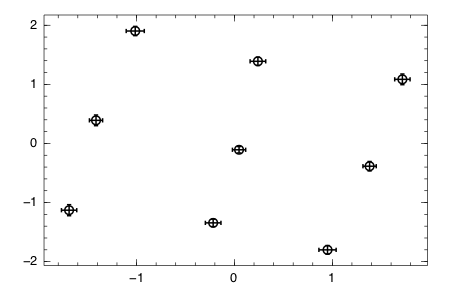

In [22]:
# Prediction
p = 0

#plotting via Winston
hold(false)
if Xfeat_local != []
    (mZ_pred, vZ_pred) = vbmds.VBMDSMix(0, Xfeat, nZ, params)
    println("Using GP")
    errbarsx = SymmetricErrorBarsX(mZ_pred[:,1], mZ_pred[:,2], 2*sqrt(vZ_pred[:,1]))
    errbarsy = SymmetricErrorBarsY(mZ_pred[:,1], mZ_pred[:,2], 2*sqrt(vZ_pred[:,2]))

    p = scatter(mZ_pred[:,1], mZ_pred[:,2])
    hold(true)
    add(p, errbarsx)
    add(p, errbarsy)
end

p = scatter(params.mu[:,1], params.mu[:,2])

hold(true)
errbarsx_z = SymmetricErrorBarsX(params.mu[:,1], params.mu[:,2], sqrt(params.s2[:,1]))
errbarsy_z = SymmetricErrorBarsY(params.mu[:,1], params.mu[:,2], sqrt(params.s2[:,2]))
add(p, errbarsx_z)
add(p, errbarsy_z)
p